In [1]:
import sys
sys.path.append("../")

In [2]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
from functools import partial
from model_code import *
from attention_model import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import inspect
import random

2024-12-12 04:46:35.885706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 04:46:35.922303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 04:46:35.940184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 04:46:35.946050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 04:46:35.968872: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1733978799.130992  112511 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733978799.225279  112511 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733978799.225381  112511 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
print(logdir)

/tmp/tmpbd5ektix/tensorboard_logs


In [6]:
symbol = input("symbol = ").strip().lower()

In [7]:
dataset_folder = f"../dataset/{symbol}_with_three_image_ema_macd"

In [8]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [9]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

I0000 00:00:1733978802.757859  112511 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733978802.757934  112511 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733978802.757948  112511 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733978802.948800  112511 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733978802.948861  112511 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-12

In [ ]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

In [13]:
def image_time_series(image_shape, days_result, units=128):
    image_time_series_model = ImageTimeSeries(units)
    
    return image_time_series_model, "image_time_series"

In [ ]:
UNITS = 256
function_transform_origin = get_open_close_prices_percent_of_last_days_result_for_three_image_dataset
model_function = image_time_series
image_shape = get_image_shape(dataset_train, index_of_image=0)
model, model_name = model_function(image_shape, days_result)

In [15]:
# batch_size = 2**int(input("batch_size = 2^x, x = ").strip())
batch_size = int(input("batch_size = ").strip())
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
max_epochs = int(input(f"max_epochs = "))
metric_mae_name = "mae"
metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
metric_mse_name = "mse"
metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
val_loss_metric_mae_to_stop = float(input("val_loss_metric_mae_to_stop = "))
val_loss_metric_mse_to_stop = float(input("val_loss_metric_mse_to_stop = "))
start_learning_rate = float(input("start_learning_rate = ").strip())
shuffle_buffer = 300
number_epochs_to_decrease_lr = int(input("number_epochs_to_decrease_lr = "))
number_epochs_to_wait = int(input("number_epochs_to_wait = "))

In [16]:
print(f"2^{np.log2(batch_size)}")
print(f"{batch_size=}")
print(f"{max_epochs=}")
print(f"{start_learning_rate=}")
print(f"{STEPS_PER_EPOCH=}")
print(f"{val_loss_metric_mae_to_stop=}")
print(f"{val_loss_metric_mse_to_stop=}")
print(f"{number_epochs_to_decrease_lr=}")
print(f"{number_epochs_to_wait=}")

2^1.584962500721156
batch_size=3
max_epochs=100
start_learning_rate=0.01
STEPS_PER_EPOCH=839
val_loss_metric_mae_to_stop=-1.0
val_loss_metric_mse_to_stop=-1.0
number_epochs_to_decrease_lr=10
number_epochs_to_wait=10


In [17]:
model_name

'image_time_series'

In [18]:
(total_data_train, total_data_test)

(2515, 64)

In [19]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(function_transform_origin, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [20]:
# for item in dataset_test_2:
#     print(item[0].shape)
#     print(item[1].shape)
#     print(item[2].shape)
#     print(item[3].shape)
#     print(item[4].shape)
#     print(item[5].shape)
#     print(item[6].shape)
    
#     item = None
#     break

In [21]:

# for (
#         list_images_30_days,
#         list_images_7_days,
#         list_images_3_days,
#         percent_change_of_open_close_in,
#     ), percent_change_of_open_close_out in dataset_train_3:
#     print(list_images_30_days.shape)
#     print(list_images_7_days.shape)
#     print(list_images_3_days.shape)
#     print(percent_change_of_open_close_in.shape)
#     print(percent_change_of_open_close_out.shape)
    
#     list_images_30_days = None
#     list_images_7_days = None
#     list_images_3_days = None
#     percent_change_of_open_close_in = None
#     percent_change_of_open_close_out = None
#     break

In [22]:
# for features, labels in dataset_train_3.take(1):
#     print(features[0].shape)
#     print(features[1].shape)
#     print(labels.shape)

In [23]:
(len(dataset_train_3), len(dataset_test_3))

(839, 22)

In [ ]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True


class SaveModelCallback(keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        folder_tmp = f"{self.save_path}/tmp_model"
        file_name = f"{folder_tmp}/model_tmp_{epoch}.keras"
        self.model.save(file_name)  # Lưu toàn bộ model
        

class TrackingLossCallback(keras.callbacks.Callback):
    def __init__(self, metric_mse_name, metric_mae_name):
        super().__init__()
        self.list_epochs = []
        self.list_val_mse_loss = []
        self.list_train_mse_loss = []
        self.list_val_mae_loss = []
        self.list_train_mae_loss = []
        self.metric_mse_name = metric_mse_name
        self.metric_mae_name = metric_mae_name
        self.val_mse_loss_key = f"val_{self.metric_mse_name}"
        self.train_mse_loss_key = f"{self.metric_mse_name}"
        self.val_mae_loss_key = f"val_{self.metric_mae_name}"
        self.train_mae_loss_key = f"{self.metric_mae_name}"

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        self.list_epochs.append(epoch)
        self.list_val_mse_loss.append(logs.get(self.val_mse_loss_key))
        self.list_train_mse_loss.append(logs.get(self.train_mse_loss_key))
        self.list_val_mae_loss.append(logs.get(self.val_mae_loss_key))
        self.list_train_mae_loss.append(logs.get(self.train_mae_loss_key))
    
    def get_df_result(self):
        df = pd.DataFrame({
            "epoch": self.list_epochs,
            self.val_mse_loss_key: self.list_val_mse_loss,
            self.train_mse_loss_key: self.list_train_mse_loss,
            self.val_mae_loss_key: self.list_val_mae_loss,
            self.train_mae_loss_key: self.list_train_mae_loss,
        })
        df.sort_values(self.val_mse_loss_key, inplace=True)
        return df

In [25]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)

tracking_loss_callback = TrackingLossCallback(metric_mse_name)
def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_mae_to_stop, metric_mae_name),
        StopAtLossValue(val_loss_metric_mse_to_stop, metric_mse_name),
        SaveModelCallback(dataset_folder),
        tracking_loss_callback,
        keras.callbacks.EarlyStopping(monitor=f'val_loss', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_mae_object,
        metric_mse_object
    ],
)


In [26]:
# Ví dụ
all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
evaluate_all_models_in_dataset_folder(
    all_models_folder_path, 
    dataset_test_2,
    days_result
)

,model_name,mse,mae


In [27]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    folder_tmp = f"{dataset_folder}/tmp_model"
    os.makedirs(folder_tmp, exist_ok=False)
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_mse_name, number_epochs_to_wait)
    )

Epoch 1/100


/home/hieucaohd/code/CNN-LSTM-predict-stock-price/.venv/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'image_time_series', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-12-12 04:47:08.795329: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


839/839 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 9.8715 - mae: 1.9853 - mse: 9.8715
Epoch: 0, loss:9.1300,  mae:1.8822,  mse:9.1300,  val_loss:4.6953,  val_mae:1.4080,  val_mse:4.6953,  
839/839 ━━━━━━━━━━━━━━━━━━━━ 183s 207ms/step - loss: 9.8706 - mae: 1.9852 - mse: 9.8706 - val_loss: 4.6953 - val_mae: 1.4080 - val_mse: 4.6953
Epoch 2/100


2024-12-12 04:50:03.227340: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-12 04:50:03.227436: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
/usr/local/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


839/839 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 4.6953 - val_mae: 1.4080 - val_mse: 4.6953
Epoch 3/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 181s 212ms/step - loss: 8.0007 - mae: 1.7400 - mse: 8.0007 - val_loss: 4.0483 - val_mae: 1.3354 - val_mse: 4.0483
Epoch 4/100


2024-12-12 04:53:12.341657: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mean_squared_error/sub/Shape/_26]]
2024-12-12 04:53:12.341830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3694610670293527553
2024-12-12 04:53:12.341845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10416104353115618293
2024-12-12 04:53:12.341852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5829941912950885509
2024-12-12 04:53:12.341869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2318951099373730935
2024-12-12 04:53:12.341876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 

839/839 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 4.0483 - val_mae: 1.3354 - val_mse: 4.0483
Epoch 5/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 176s 208ms/step - loss: 7.0796 - mae: 1.6629 - mse: 7.0796 - val_loss: 3.3543 - val_mae: 1.2818 - val_mse: 3.3543
Epoch 6/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.3543 - val_mae: 1.2818 - val_mse: 3.3543
Epoch 7/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 174s 205ms/step - loss: 6.1939 - mae: 1.6101 - mse: 6.1939 - val_loss: 3.4306 - val_mae: 1.3049 - val_mse: 3.4306
Epoch 8/100


2024-12-12 04:59:16.110931: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mean_squared_error/sub/Shape/_26]]
2024-12-12 04:59:16.111154: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3694610670293527553
2024-12-12 04:59:16.111164: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 16212156025217726085
2024-12-12 04:59:16.111168: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 13659923981527758597
2024-12-12 04:59:16.111173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10416104353115618293
2024-12-12 04:59:16.111178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash

839/839 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.4306 - val_mae: 1.3049 - val_mse: 3.4306
Epoch 9/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 172s 203ms/step - loss: 6.5296 - mae: 1.6387 - mse: 6.5296 - val_loss: 3.9209 - val_mae: 1.4051 - val_mse: 3.9209
Epoch 10/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.9209 - val_mae: 1.4051 - val_mse: 3.9209
Epoch 11/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 185s 218ms/step - loss: 6.0862 - mae: 1.5984 - mse: 6.0862 - val_loss: 3.3465 - val_mae: 1.2989 - val_mse: 3.3465
Epoch 12/100


2024-12-12 05:05:32.316488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3694610670293527553
2024-12-12 05:05:32.316860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10416104353115618293
2024-12-12 05:05:32.316874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5829941912950885509
2024-12-12 05:05:32.316881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2318951099373730935
2024-12-12 05:05:32.316887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4338022324332526885
2024-12-12 05:05:32.317425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9208902580134126120
2024-12-12 05:05:32.317440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

839/839 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.3465 - val_mae: 1.2989 - val_mse: 3.3465
Epoch 13/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 182s 214ms/step - loss: 6.1977 - mae: 1.6061 - mse: 6.1977 - val_loss: 3.2716 - val_mae: 1.2549 - val_mse: 3.2716
Epoch 14/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.2716 - val_mae: 1.2549 - val_mse: 3.2716
Epoch 15/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 178s 210ms/step - loss: 6.2272 - mae: 1.6050 - mse: 6.2272 - val_loss: 3.3407 - val_mae: 1.2354 - val_mse: 3.3407
Epoch 16/100


2024-12-12 05:11:49.347546: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]


839/839 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.3407 - val_mae: 1.2354 - val_mse: 3.3407
Epoch 17/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 181s 213ms/step - loss: 6.4112 - mae: 1.6245 - mse: 6.4112 - val_loss: 3.3577 - val_mae: 1.2330 - val_mse: 3.3577
Epoch 18/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.3577 - val_mae: 1.2330 - val_mse: 3.3577
Epoch 19/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 181s 212ms/step - loss: 6.1678 - mae: 1.5990 - mse: 6.1678 - val_loss: 3.3052 - val_mae: 1.2403 - val_mse: 3.3052
Epoch 20/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.3052 - val_mae: 1.2403 - val_mse: 3.3052
Epoch 21/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 177s 207ms/step - loss: 6.6790 - mae: 1.6656 - mse: 6.6790 - val_loss: 3.3835 - val_mae: 1.2354 - val_mse: 3.3835
Epoch 22/100
839/839 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/s

In [28]:
loss = model.evaluate(dataset_test_3, verbose=2)

22/22 - 1s - 53ms/step - loss: 3.3233 - mae: 1.2415 - mse: 3.3233


In [29]:
loss

[3.3233330249786377, 1.2414765357971191, 3.323333263397217]

In [30]:
def get_folder_path_to_save_model(model_name):
    new_model_name = model_name
    path_save = f"{dataset_folder}/model_save/{new_model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        random_index = random.randint(0, 100)
        new_model_name = new_model_name + f"_{random_index}"
        path_save = f"{dataset_folder}/model_save/{new_model_name}"
        print(f"-- Change to {path_save}")
    os.makedirs(path_save, exist_ok=False)
    return path_save, new_model_name 

In [31]:
def save_model(model: keras.Sequential, folder_path, new_model_name):
    path_save = f"{folder_path}/{new_model_name}.keras"
    abspath_save = os.path.abspath(path_save)
    model.save(abspath_save)
    return path_save

In [32]:
def save_model_and_config(model: keras.Sequential, epoch):
    folder_path, new_model_name = get_folder_path_to_save_model(f"{model_name}_epoch_{epoch}")
    model_name_saved = save_model(model, folder_path, new_model_name)
    loss = model.evaluate(dataset_test_3)
    config_and_loss = {
        "config": {
            "batch_size": batch_size,
            "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
            "name_sub_folder_save_metrics": name_sub_folder_save_metrics,
            "name_folder_save_metrics": name_folder_save_metrics,
            "max_epochs": max_epochs,
            "val_loss_metric_mae_to_stop": val_loss_metric_mae_to_stop,
            "val_loss_metric_mse_to_stop": val_loss_metric_mse_to_stop,
            "start_learning_rate": start_learning_rate,
            "shuffle_buffer": shuffle_buffer,
            "number_epochs_to_decrease_lr": number_epochs_to_decrease_lr,
            "number_epochs_to_wait": number_epochs_to_wait,
            "model_function": function_transform_origin.__name__,
            "time_created": str(datetime.now()),
            "epoch": epoch
        },
        "loss": {
            "val_mse_loss": loss[0],
            "val_mae_loss": loss[1],
        }
    }
    with open(f"{folder_path}/config_and_loss.json", "w") as file:
        json.dump(config_and_loss, file, indent=2)
    code_str = inspect.getsource(model_function)
    with open(f"{folder_path}/model_function_code.py", "w", encoding="utf8") as file:
        file.write(code_str)
    
    return new_model_name

In [33]:
list_name_models = []
list_models = []
df_result = tracking_loss_callback.get_df_result()

In [34]:
df_result

,epoch,val_mse,mse
13,13,3.271569,0.000000
12,12,3.271569,6.706611
19,19,3.305242,0.000000
18,18,3.305242,6.515516
23,23,3.323333,0.000000
22,22,3.323333,6.645270
15,15,3.340685,0.000000
14,14,3.340685,6.674662
11,11,3.346451,0.000000
10,10,3.346452,6.719624


In [63]:
now = datetime.now()
result = now.strftime("%Y-%m-%d %H:%M:%S")
df_result.sort_values("epoch").to_excel(f"{dataset_folder}/loss_train/{result}.xlsx", index=False)

In [44]:
if input("save model? (y/n): ").lower()[0] == "y":
    is_save_model_from_tmp = input("Save model from tmp file? (y/n): ").lower()[0] == "y"
    
    if is_save_model_from_tmp:
        while True and os.path.exists(folder_tmp):
            epoch = input(f"Epoch = (s for stop)")
            if not str.isdigit(epoch):
                break
            else:
                epoch = int(epoch)
            
            model_tmp_name = f"model_tmp_{epoch}.keras"
            print(f"Save {model_tmp_name}")
            model_tmp_path = f"{folder_tmp}/{model_tmp_name}"
            if not os.path.exists(model_tmp_path):
                print(f"model {model_tmp_path} does not exist.")
                continue
            
            try:
                model_tmp = keras.models.load_model(model_tmp_path)
                name_model_tmp_saved = save_model_and_config(model_tmp, epoch)
                list_name_models.append(name_model_tmp_saved)
                list_models.append(model_tmp)
            except Exception as err:
                print(err)
                continue
    
    is_save_last_model = input("Save last model? (y/n): ").lower()[0] == "y"
    if is_save_last_model:
        name_last_model_saved = save_model_and_config(model, "last")
        list_name_models.append(name_last_model_saved)
        list_models.append(model)

is_delete_tmp_model_folder = input("Delete model tmp folder? (y/n): ").lower()[0] == "y"
if is_delete_tmp_model_folder:
    if os.path.exists(folder_tmp):
        shutil.rmtree(folder_tmp)
    else:
        print(f"{folder_tmp} does not exist.")
    

Save model_tmp_9.keras
<class 'attention_model.ImageTimeSeries'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'attention_model', 'class_name': 'ImageTimeSeries', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'ImageTimeSeries', 'build_config': {'input_shape': [[None, 287, 287, 3], [None, 287, 287, 3], [None, 287, 287, 3], [None, 3, 2]]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': {'module': 'keras.optimizers.schedules', 'class_name': 'InverseTimeDecay', 'config': {'initial_learning_rate': 0.01, 'decay_steps': 8390, 'decay_rate': 1, 'staircase': False, 'name': 'InverseTimeDecay'}, 'registered_name': 

In [45]:
for model_loaded, model_name_loaded in zip(list_models, list_name_models):
    loss = model_loaded.evaluate(dataset_test_3)
    print(f"{model_name_loaded}: {loss}")

In [46]:
size_histories = {}

In [47]:
size_histories[name_sub_folder_save_metrics] = history 

(3.2573320698738097, 4.709500329494476)

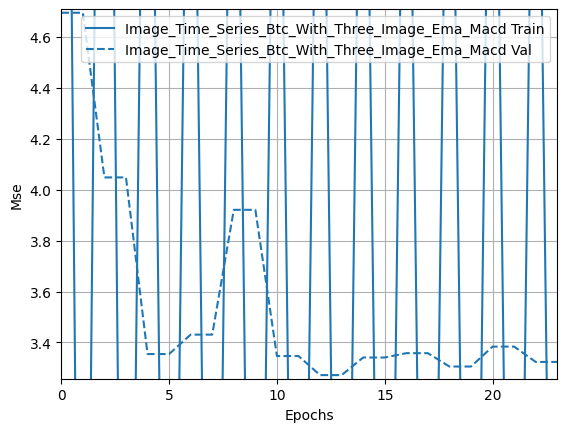

In [ ]:
min_val_loss = df_result[tracking_loss_callback.val_mse_loss_key].min()
max_val_loss = df_result[tracking_loss_callback.val_mse_loss_key].max()
scale = (max_val_loss - min_val_loss) / 100
plotter = tfdocs.plots.HistoryPlotter(metric=metric_mse_name)
plotter.plot(size_histories)
plt.ylim([min_val_loss - scale, max_val_loss + scale])

(-0.09129958152770996, 9.221257734298707)

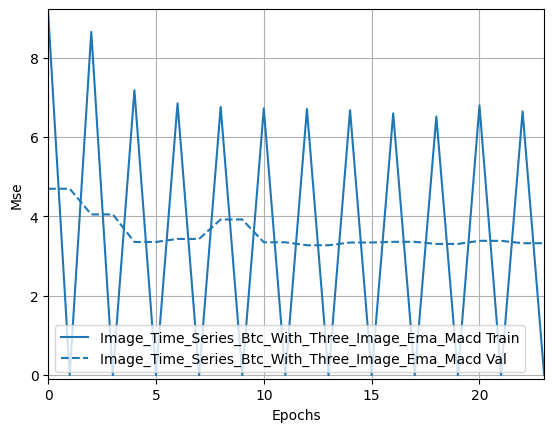

In [ ]:
min_train_loss = df_result[tracking_loss_callback.train_mse_loss_key].min()
max_train_loss = df_result[tracking_loss_callback.train_mse_loss_key].max()
scale = (max_train_loss - min_train_loss) / 100
plotter = tfdocs.plots.HistoryPlotter(metric=metric_mse_name)
plotter.plot(size_histories)
plt.ylim([min_train_loss - scale, max_train_loss + scale])

In [50]:
# train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
# test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')
# for x_train, y_train, date_train in train_dataset.take(2):
#     pass
# for x_test, y_test, date_test in test_dataset.take(2):
#     pass
# plt.imshow(x_train)
# y_train
# plt.imshow(x_test)
# y_test

In [51]:
list_name_models

[]

In [52]:
dataset_folder

'../dataset/btc_with_three_image_ema_macd'